In [1]:
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from pathlib import Path, PurePath
import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import pickle
from joblib import Parallel, delayed, dump, load
from shutil import rmtree
from collections import defaultdict

import timeit

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.feature_selection import RFECV

from sklearn.base import clone

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from cuml.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from cuml.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import catboost as cb
from catboost import CatBoostClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm

In [2]:
rlist = []
records = PurePath(Path(os.getcwd()).parents[1], Path('mit-bih-dataframes/subject_list.csv'))
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [3]:
def classify_rr_ints(df):
    #list of types of rr_ints for each subject
    subject_types = []
    for row in df.itertuples():
        if row.rrInt < 0.85*row.rmean: 
            #if rr_ints is less than 85% of runningmean
            #label subject type as short
            subject_types.append('short')
        elif row.rrInt > 1.15*row.rmean: 
            #if rr_ints is greater than 115% of runningmean
            #label subject type as long
            subject_types.append('long')
        else:
            #label subject type as regular
            subject_types.append('regular')
    
    return subject_types

In [4]:
def find_proportions(int_types):
    StoS = 0
    StoR = 0
    StoL = 0
    RtoS = 0
    RtoR = 0
    RtoL = 0
    LtoS = 0
    LtoR = 0
    LtoL = 0
    for idx in range(len(int_types)):
        if idx<len(int_types)-1:
            if int_types[idx]=='short' and int_types[idx+1]=='short':
                StoS+=1
            elif int_types[idx]=='short' and int_types[idx+1]=='regular':
                StoR+=1
            elif int_types[idx]=='short' and int_types[idx+1]=='long':
                StoL+=1
            elif int_types[idx]=='regular' and int_types[idx+1]=='short':
                RtoS+=1
            elif int_types[idx]=='regular' and int_types[idx+1]=='regular':
                RtoR+=1
            elif int_types[idx]=='regular' and int_types[idx+1]=='long':
                RtoL+=1
            elif int_types[idx]=='long' and int_types[idx+1]=='short':
                LtoS+=1
            elif int_types[idx]=='long' and int_types[idx+1]=='regular':
                LtoR+=1
            elif int_types[idx]=='long' and int_types[idx+1]=='long':
                LtoL+=1
    
    count = len(int_types)-1
    subject_transitions = [StoS/count, StoR/count, StoL/count, RtoS/count, RtoR/count, RtoL/count, LtoS/count, LtoR/count, LtoL/count]
    
    return subject_transitions

In [5]:
def extract_rmssd(subset):
    rrInts = subset['rrInt'].tolist()
    sum_of_squares = 0
    for idx, rrInt in enumerate(rrInts):
        if idx<len(rrInts)-1:
            square_difference = (rrInt-rrInts[idx-1])**2
            sum_of_squares+=square_difference
    mean_sum = sum_of_squares/(len(rrInts)-1)
    return np.sqrt(mean_sum)

In [6]:
def subset_features(subset_list, current_weight = 0.25, prev_weight = 0.75):
    subset_dfs = {}
    for x, subset in enumerate(subset_list.itertuples()):
        subset_dfs[x] = pd.read_parquet(os.path.normpath(str(Path(os.getcwd()).parents[1]) + '/mit-bih-time-subsets/'+str(subset.subjectID)+'/'+str(subset.subjectID)+"-"+str(x)+".parquet"))

    calib_df = subset_dfs[0]

    feature_dict = {}

    props = find_proportions(classify_rr_ints(calib_df))
    feature_dict['StoS'] = [props[0]]
    feature_dict['StoR'] = [props[1]]
    feature_dict['StoL'] = [props[2]]
    feature_dict['RtoS'] = [props[3]]
    feature_dict['RtoR'] = [props[4]]
    feature_dict['RtoL'] = [props[5]]
    feature_dict['LtoS'] = [props[6]]
    feature_dict['LtoR'] = [props[7]]
    feature_dict['LtoL'] = [props[8]]

    feature_dict['std'] = [np.std(calib_df['rrInt'])]
    feature_dict['cov'] = [feature_dict['std'][0]/np.mean(calib_df['rrInt'])]
    feature_dict['range'] = [np.max(calib_df['rrInt'])-np.min(calib_df['rrInt'])]
    #feature_dict['rmean'] = df['rmean'].tolist()
    #feature_dict['rrv'] = df['rr_variance'].tolist()
    feature_dict['rrInt_var'] = [calib_df['rrInt'].var()]
    feature_dict['rmean_var'] = [calib_df['rmean'].var()]
    feature_dict['rmssd'] = [extract_rmssd(calib_df)]
    feature_dict['mad'] = [stats.median_abs_deviation(calib_df['rrInt'])]
    feature_dict['iqr'] = [stats.iqr(calib_df['rrInt'])]

    drr = np.diff(calib_df['rrInt'])
    feature_dict['drrmean'] = [np.mean(drr)]
    feature_dict['drrvar'] = [np.var(drr)]
    
    for key in subset_dfs:
        if key>0:
            current_subset = subset_dfs[key]
            props = find_proportions(classify_rr_ints(current_subset))
            feature_dict['StoS'].append(props[0]*current_weight + feature_dict['StoS'][key-1]*prev_weight)
            feature_dict['StoR'].append(props[1]*current_weight + feature_dict['StoR'][key-1]*prev_weight)
            feature_dict['StoL'].append(props[2]*current_weight + feature_dict['StoL'][key-1]*prev_weight)
            feature_dict['RtoS'].append(props[3]*current_weight + feature_dict['RtoS'][key-1]*prev_weight)
            feature_dict['RtoR'].append(props[4]*current_weight + feature_dict['RtoR'][key-1]*prev_weight)
            feature_dict['RtoL'].append(props[5]*current_weight + feature_dict['RtoL'][key-1]*prev_weight)
            feature_dict['LtoS'].append(props[6]*current_weight + feature_dict['LtoS'][key-1]*prev_weight)
            feature_dict['LtoR'].append(props[7]*current_weight + feature_dict['LtoR'][key-1]*prev_weight)
            feature_dict['LtoL'].append(props[8]*current_weight + feature_dict['LtoL'][key-1]*prev_weight)

            feature_dict['std'].append(np.std(current_subset['rrInt'])*current_weight + feature_dict['std'][key-1]*prev_weight)
            feature_dict['cov'].append((feature_dict['std'][key]/np.mean(current_subset['rrInt']))*current_weight + feature_dict['cov'][key-1]*prev_weight)
            feature_dict['range'].append(np.max(current_subset['rrInt'])-np.min(current_subset['rrInt'])*current_weight + feature_dict['range'][key-1]*prev_weight)
            #feature_dict['rmean'] = df['rmean'].tolist()
            #feature_dict['rrv'] = df['rr_variance'].tolist()
            feature_dict['rrInt_var'].append(current_subset['rrInt'].var()*current_weight + feature_dict['rrInt_var'][key-1]*prev_weight)
            feature_dict['rmean_var'].append(current_subset['rmean'].var()*current_weight + feature_dict['rmean_var'][key-1]*prev_weight)
            feature_dict['rmssd'].append(extract_rmssd(current_subset)*current_weight + feature_dict['rmssd'][key-1]*prev_weight)
            feature_dict['mad'].append(stats.median_abs_deviation(current_subset['rrInt'])*current_weight + feature_dict['mad'][key-1]*prev_weight)
            feature_dict['iqr'].append(stats.iqr(current_subset['rrInt'])*current_weight + feature_dict['iqr'][key-1]*prev_weight)

            drr = np.diff(calib_df['rrInt'])
            feature_dict['drrmean'].append(np.mean(drr)*current_weight + feature_dict['drrmean'][key-1]*prev_weight)
            feature_dict['drrvar'].append(np.var(drr)*current_weight + feature_dict['drrvar'][key-1]*prev_weight)

    feature_df = pd.DataFrame(data=feature_dict)
    return pd.concat([subset_list, feature_df], axis=1)

In [7]:
current_weight = 0.5

In [8]:
if not os.path.exists(str(Path(os.getcwd()).parents[1]) + '/mit-bih-time-features/'):
    os.mkdir(str(Path(os.getcwd()).parents[1]) + '/mit-bih-time-features/')

subset_lists = []
for record in rlist:
    subset_lists.append(pd.read_parquet(os.path.normpath(str(Path(os.getcwd()).parents[1]) + '/mit-bih-time-subsets/'+record+'_subset_list.parquet')))
    
features_list = Parallel(n_jobs=8, verbose=12)(
    delayed(subset_features)(subset_list, current_weight, 1-current_weight)
    for subset_list in subset_lists
)

for idx, record in enumerate(rlist):
    features_list[idx].to_parquet(os.path.normpath(str(Path(os.getcwd()).parents[1]) + '/mit-bih-time-features/'+record+".parquet"))
    
print("Feature extraction complete")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   18.8s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:   20.8s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:   20.9s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:   23.3s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:   25.3s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:   28.7s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:   29.0s
[Parallel(n_jobs=8)]: Done  10 out of  23 | elapsed:   41.4s remaining:   53.8s
[Parallel(n_jobs=8)]: Done  12 out of  23 | elapsed:   42.3s remaining:   38.8s
[Parallel(n_jobs=8)]: Done  14 out of  23 | elapsed:   50.7s remaining:   32.6s
[Parallel(n_jobs=8)]: Done  16 out of  23 | elapsed:   55.9s remaining:   24.4s
[Parallel(n_jobs=8)]: Done  18 out of  23 | elapsed:  1.0min remaining:   16.7s
[Parallel(n_jobs=8)]: Done  20 out of

Feature extraction complete


In [9]:
feature_dfs = {}
for record in tqdm(rlist):
    feature_dfs[record] = pd.read_parquet(str(Path(os.getcwd()).parents[1]) + '/mit-bih-time-features/'+record+'.parquet')

combined_features = pd.concat([feature_dfs[key][1:] for key in feature_dfs])

  0%|          | 0/23 [00:00<?, ?it/s]

In [10]:
X = combined_features[['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'std', 'cov', 'range', 'rrInt_var', 'rmean_var', 'rmssd', 'mad', 'iqr']]#, 'drrmean', 'drrvar']]
y = combined_features['mappedLabel'].map({"Non-Afib": 0, "Afib": 1})
groups = combined_features['subjectID'].astype('int64')

logo = LeaveOneGroupOut()
splits = list(logo.split(X, y, groups=groups))

In [11]:
np.seterr(all='ignore')
moving_accs = []

if os.path.exists(f'saved_results_{current_weight}')==False:
    os.mkdir(f'saved_results_{current_weight}')

In [36]:
def score_reporter(results, importances=True, moving_acc_plot=False, classifier_name="idk"):
    bestParams = None
    maxScore = 0
    for params, scores in results.items():
        num_splits = scores['folds']
        accuracy = [scores[f"split{i}_accuracy"] for i in range(num_splits)]
        print(params, np.mean(accuracy))
        
        if (np.mean(accuracy) > maxScore):
            bestParams = params
            maxScore = np.mean(accuracy)
            
    bestScores = results[bestParams]
    num_splits = bestScores['folds']
    accuracy = [bestScores[f"split{i}_accuracy"] for i in range(num_splits)]
    sensitivity = [bestScores[f"split{i}_sensitivity"] for i in range(num_splits)]
    specificity = [bestScores[f"split{i}_specificity"] for i in range(num_splits)]
    precision = [bestScores[f"split{i}_precision"] for i in range(num_splits)]
    f1_score = [bestScores[f"split{i}_f1_score"] for i in range(num_splits)]
    if importances:
        feature_importances = [list(bestScores[f"split{i}_feature_importances"].values()) for i in range(num_splits)]
    
        avg_importances = np.mean(np.array(feature_importances), axis=0)
        feature_names = list(bestScores["split0_feature_importances"].keys())[0]
        mapped_importances = {name: rank for name, rank in zip(feature_names, avg_importances.flatten())}
        
    if moving_acc_plot:
        subject_accs = [bestScores[f"split{i}_subject_acc"] for i in range(num_splits)]
        minLen = len(subject_accs[0])
        for accs in subject_accs:
            if len(accs)<minLen:
                minLen = len(accs)

        avg_list = [sum(sub_list) * 100 / len(sub_list) for sub_list in zip(*subject_accs)]
        plt.plot(avg_list)
        plt.title(classifier_name + " Accuracy Over Time")
        plt.xlabel("Stepping windows elapsed")
        plt.ylabel("Average accuracy across CV folds (%)")
        plt.show()
    
    print(f"The best parameters were {bestParams}")
    print(f"Accuracy for each fold: {accuracy}")
    print(f"Mean accuracy: {np.nanmean(accuracy)}")
    print(f"Std accuracy: {np.nanstd(accuracy)}")
    print(f"Sensitivity for each fold: {sensitivity}")
    print(f"Mean sensitivity: {np.nanmean(sensitivity)}")
    print(f"Std sensitivity: {np.nanstd(sensitivity)}")
    print(f"Specificity for each fold: {specificity}")
    print(f"Mean specificity: {np.nanmean(specificity)}")
    print(f"Std specificity: {np.nanstd(specificity)}")
    print(f"Precision for each fold: {precision}")
    print(f"Mean precision: {np.nanmean(precision)}")
    print(f"Std precision: {np.nanstd(precision)}")
    print(f"F1-score for each fold: {f1_score}")
    print(f"Mean F1-score: {np.nanmean(f1_score)}")
    print(f"Std F1-score: {np.nanstd(f1_score)}")
    if importances:
        print("Average feature importances: ")
        print(mapped_importances)

In [38]:
def fit_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train, y_train)

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "subject_acc": subject_acc
    }
    
    return results_dict

In [14]:
def fit_xgboost_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train, y_train)

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "feature_importances": {A: B for A, B in zip(cloned_clf.feature_names_in_, cloned_clf.feature_importances_)},
        "subject_acc": subject_acc
    }
    
    return results_dict

In [16]:
def fit_catboost_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train, y_train)

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "feature_importances": {A: B for A, B in zip(cloned_clf.feature_names_, cloned_clf.feature_importances_)},
        "subject_acc": subject_acc
    }
    
    return results_dict

In [17]:
def fit_lightgbm_parallel(clf, X, y, train, test, **fit_params):
    np.seterr(all='ignore')
    
    X_train = X.iloc[train]
    y_train = y.iloc[train]

    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    cloned_clf = clone(clf)
    cloned_clf.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], 
                   eval_metric='logloss')

    pred_values = cloned_clf.predict(X_test)
    
    total_seen = 0
    total_correct = 0
    subject_acc = []
    for idx, pred in enumerate(pred_values):
        total_seen+=1
        if pred==y_test.iloc[idx]:
            total_correct+=1
        subject_acc.append(total_correct/total_seen)

    cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    specificity = cm[1][1]/(cm[1][0]+cm[1][1])
    precision = (cm[0][0])/(cm[0][0]+cm[1][0])

    results_dict = {
        "accuracy": accuracy_score(y_test, pred_values),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
        "feature_importances": {A: B for A, B in zip(cloned_clf.feature_name_, cloned_clf.feature_importances_)},
        "subject_acc": subject_acc
    }
    
    return results_dict

In [41]:
# Logistic regression
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "solver": ["liblinear"]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = LogisticRegression(max_iter=3000,
                                 **fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/lr_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('solver', 'liblinear'),) 0.8872859217202083


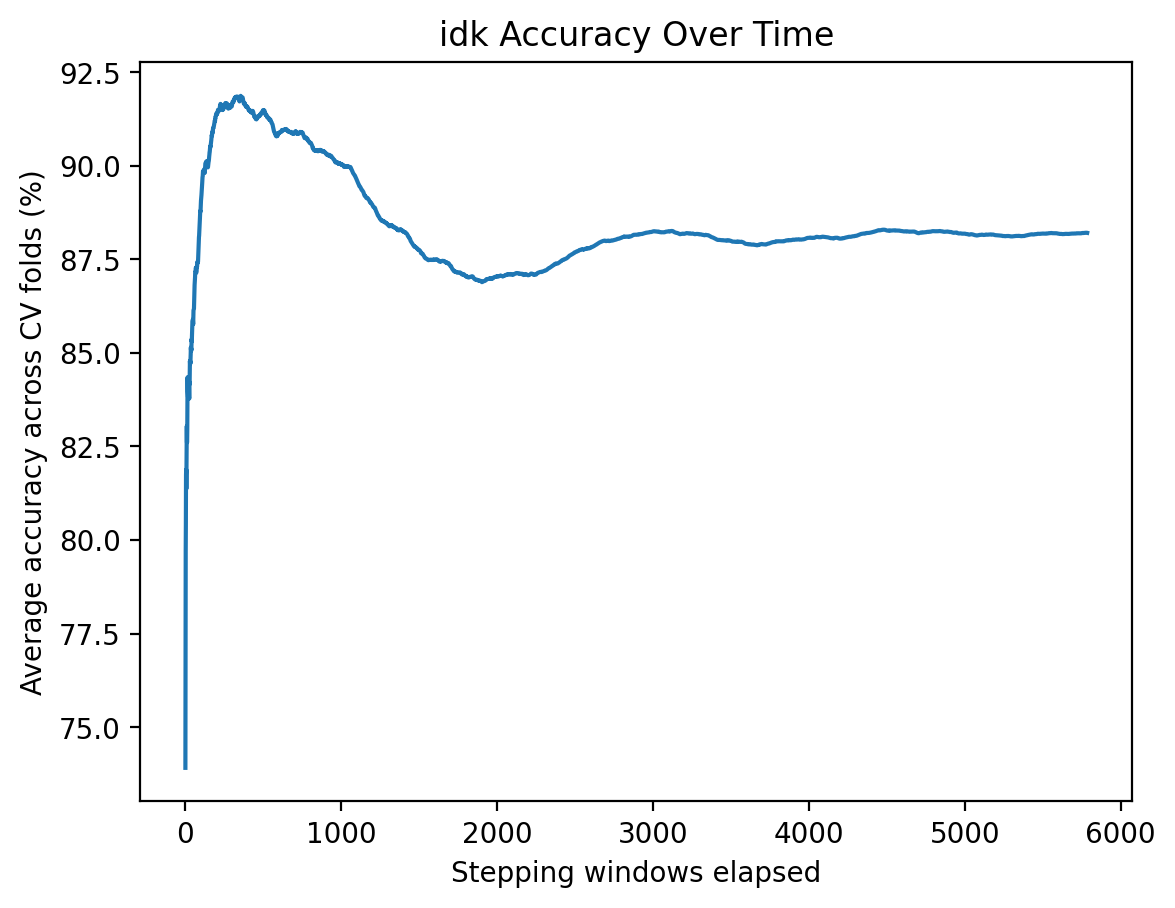

The best parameters were (('solver', 'liblinear'),)
Accuracy for each fold: [0.8987012987012987, 0.9503931657120668, 0.9950226244343892, 0.8816676024705222, 0.9761336515513126, 0.9249635036496351, 0.8570948217888366, 0.9648060238991651, 0.8895720313441833, 0.8409301096578148, 0.9606367898811471, 0.960082944530845, 0.7819172113289761, 0.8050873429359485, 0.5683790523690773, 0.9532650448143406, 0.9783148485350107, 0.8166551006245663, 0.5720949097546136, 0.9339323467230444, 0.9821264426514146, 0.9293264874660223, 0.9864728447405613]
Mean accuracy: 0.8872859217202083
Std accuracy: 0.11499154182326277
Sensitivity for each fold: [0.8977445689774457, 0.9591186958736627, 0.9952270977675135, 0.8723598237349947, 0.996090973702914, 0.9211176786673831, 0.8713602781399391, 0.9654945777193559, 0.8989861058956065, 0.8377867746288798, 0.6716867469879518, 0.9660423595308945, 0.6368763557483731, nan, nan, 0.975240206947524, 0.9802604802604803, 0.977474807350326, 0.4424719701014415, 0.9729442970822281, 0

In [42]:
score_reporter(results, False, True)

In [43]:
# LDA
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "solver": ["lsqr"]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = LinearDiscriminantAnalysis(**fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/lda_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('solver', 'lsqr'),) 0.8864452702228047


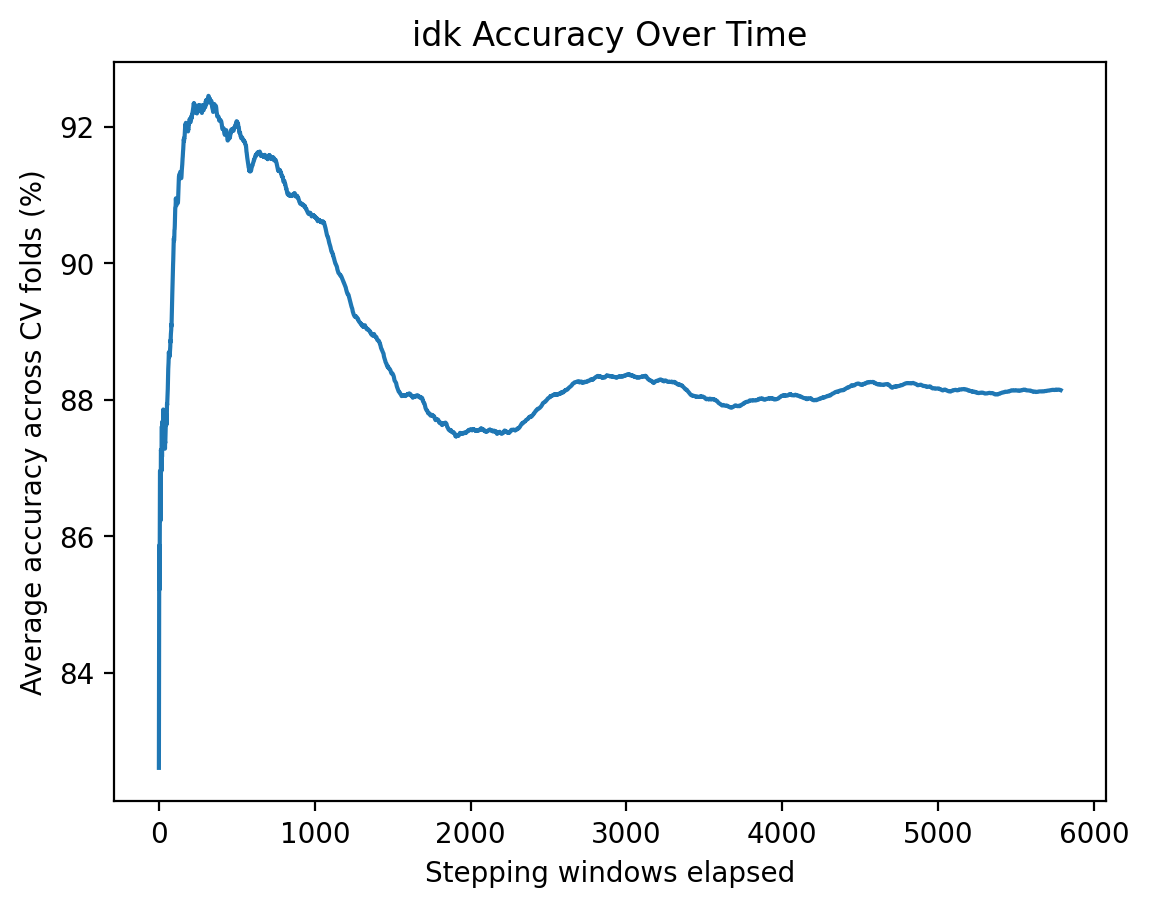

The best parameters were (('solver', 'lsqr'),)
Accuracy for each fold: [0.9036226930963773, 0.9403941364916028, 0.9932126696832579, 0.8826501965188096, 0.9693505840974752, 0.927007299270073, 0.8587760591795561, 0.9631690947781961, 0.8695599758890898, 0.8596908442330559, 0.9585650419801548, 0.9630205633316054, 0.791285403050109, 0.839564817652467, 0.4714214463840399, 0.9278702518139138, 0.9766594934613475, 0.8227619708535739, 0.6454066112350436, 0.922568710359408, 0.9813093657440507, 0.9361220175173663, 0.984251968503937]
Mean accuracy: 0.8864452702228047
Std accuracy: 0.1178985722624186
Sensitivity for each fold: [0.9028642590286425, 0.9625573102394295, 0.993841416474211, 0.8737273970521198, 0.9968017057569296, 0.9253089736700698, 0.8900478053020426, 0.9641800854419981, 0.9162598573037927, 0.8569500674763832, 0.6445783132530121, 0.9698932259758446, 0.6724511930585684, nan, nan, 0.942719881744272, 0.9820919820919821, 0.9863663307646711, 0.5459156433529098, 0.9748894783377542, 0.97186813

In [44]:
score_reporter(results, False, True)

In [45]:
# QDA
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "fake": ["param"]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = QuadraticDiscriminantAnalysis()
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/qda_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

/home/ari/mambaforge/envs/afib/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ari/mambaforge/envs/afib/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ari/mambaforge/envs/afib/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ari/mambaforge/envs/afib/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ari/mambaforge/envs/afib/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ari/mambaforge/envs/afib/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning:

(('fake', 'param'),) 0.736888012247999


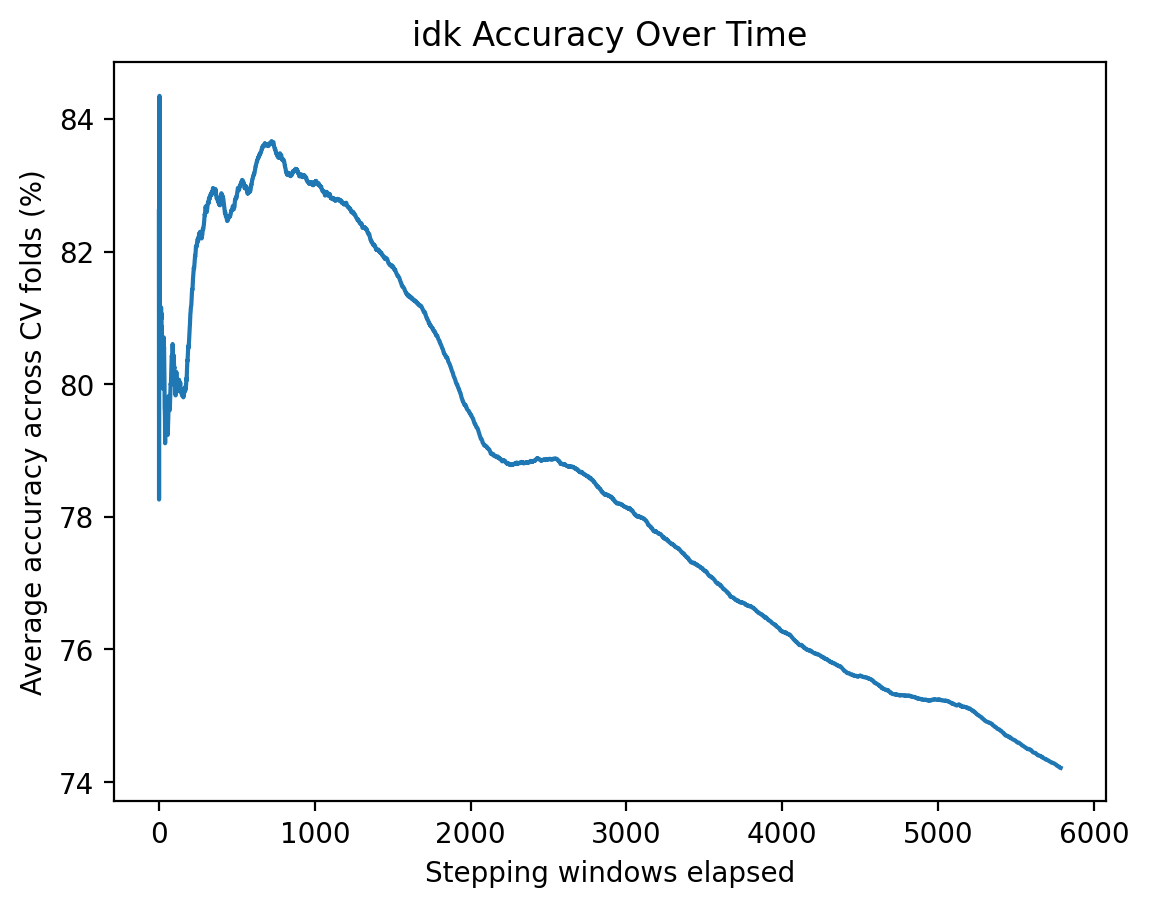

The best parameters were (('fake', 'param'),)
Accuracy for each fold: [0.9506493506493506, 0.8380739734006407, 0.979788838612368, 0.748736664795059, 0.8269061675668886, 0.9249635036496351, 0.6605021295673615, 0.9746275986249795, 0.6329113924050633, 0.8820187607345752, 0.7964235088867081, 0.9659581821323656, 0.624400871459695, 0.43962611094085197, 0.043291770573566084, 0.7955612462654716, 0.8453898361198477, 0.5070090215128383, 0.6860677347394037, 0.8249207188160677, 0.6664283525686855, 0.9343098761703413, 0.3998586715122148]
Mean accuracy: 0.736888012247999
Std accuracy: 0.22134082016099807
Sensitivity for each fold: [0.9607029196070292, 0.9882832399388691, 0.998306389530408, 0.7716152560401155, 0.9609097370291401, 0.9570123589468028, 0.6849196001738375, 0.9766677620768978, 0.8182500938790838, 0.89527665317139, 0.6355421686746988, 0.9754944862594084, 0.4429501084598699, nan, nan, 0.885809312638581, 0.9625559625559625, 0.9857735625370481, 0.8107314468766684, 0.9747126436781609, 0.978021

In [46]:
score_reporter(results, False, True)

In [47]:
# KNN
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_neighbors": [9]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = KNeighborsClassifier(**fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/knn_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('n_neighbors', 9),) 0.8770189060632726


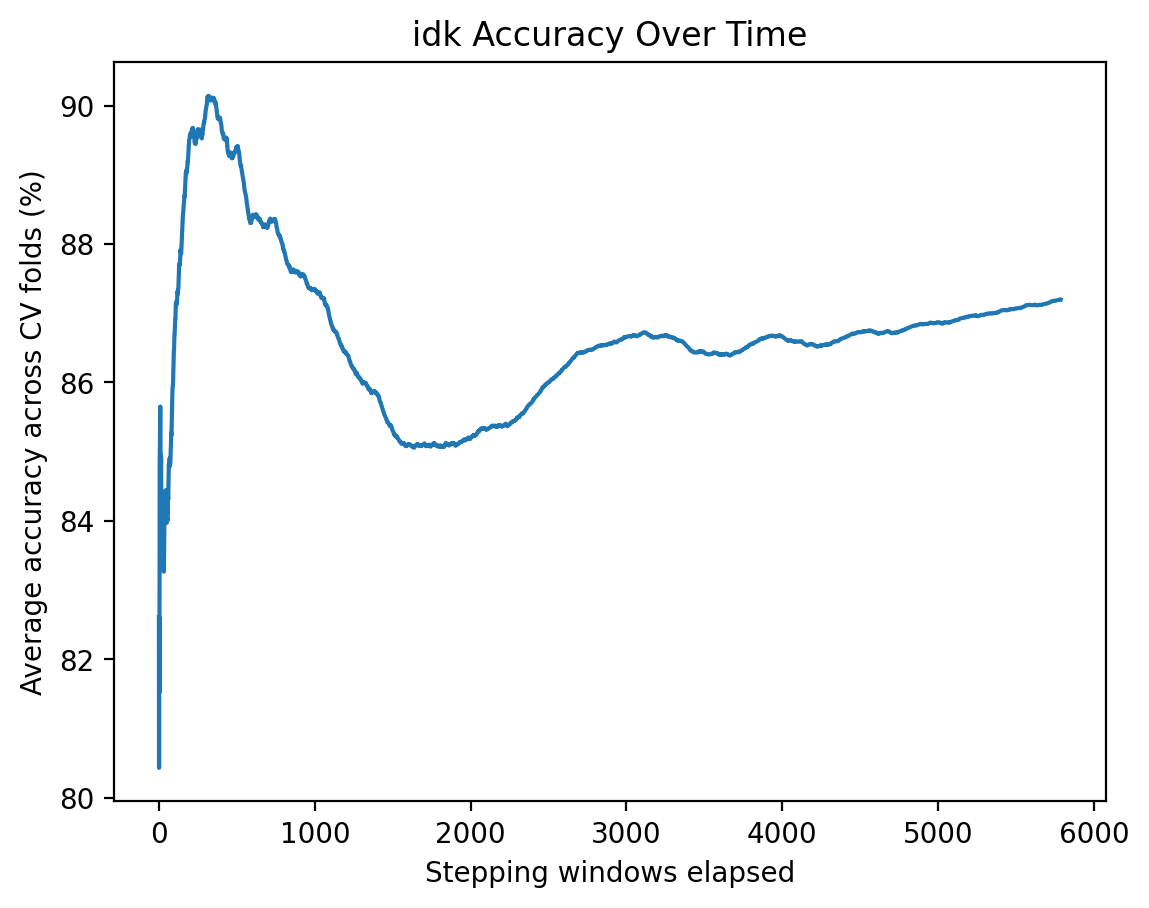

The best parameters were (('n_neighbors', 9),)
Accuracy for each fold: [0.8773752563226247, 0.9493253082225027, 0.9844645550527904, 0.7281021897810219, 0.9756312021102876, 0.904720194647202, 0.8809683927370545, 0.9649697168112621, 0.8875226039783002, 0.7756638921918351, 0.9628175771453494, 0.9398652151373769, 0.7351851851851852, 0.843548881397487, 0.6882793017456359, 0.9606274007682458, 0.9167356397947359, 0.932824427480916, 0.4827621172176029, 0.9126585623678647, 0.970074558267797, 0.9155844155844156, 0.981728245507773]
Mean accuracy: 0.8770189060632726
Std accuracy: 0.11891667993316793
Sensitivity for each fold: [0.8758821087588211, 0.9493122771268466, 0.9849114703618168, 0.7061236894089045, 0.9680170575692963, 0.8961848468565288, 0.757496740547588, 0.9658232007886953, 0.8452872699962448, 0.7715249662618083, 0.5843373493975904, 0.9429371608611937, 0.4913232104121475, nan, nan, 0.9338507021433851, 0.9043549043549044, 0.9561351511558981, 0.32234383342231715, 0.9138815207780725, 0.96307

In [48]:
score_reporter(results, False, True)

In [49]:
# Decision tree
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "max_depth": [None]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = DecisionTreeClassifier(**fit_params)
        
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train, y_train)

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/dt_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

(('max_depth', None),) 0.9039870911251064


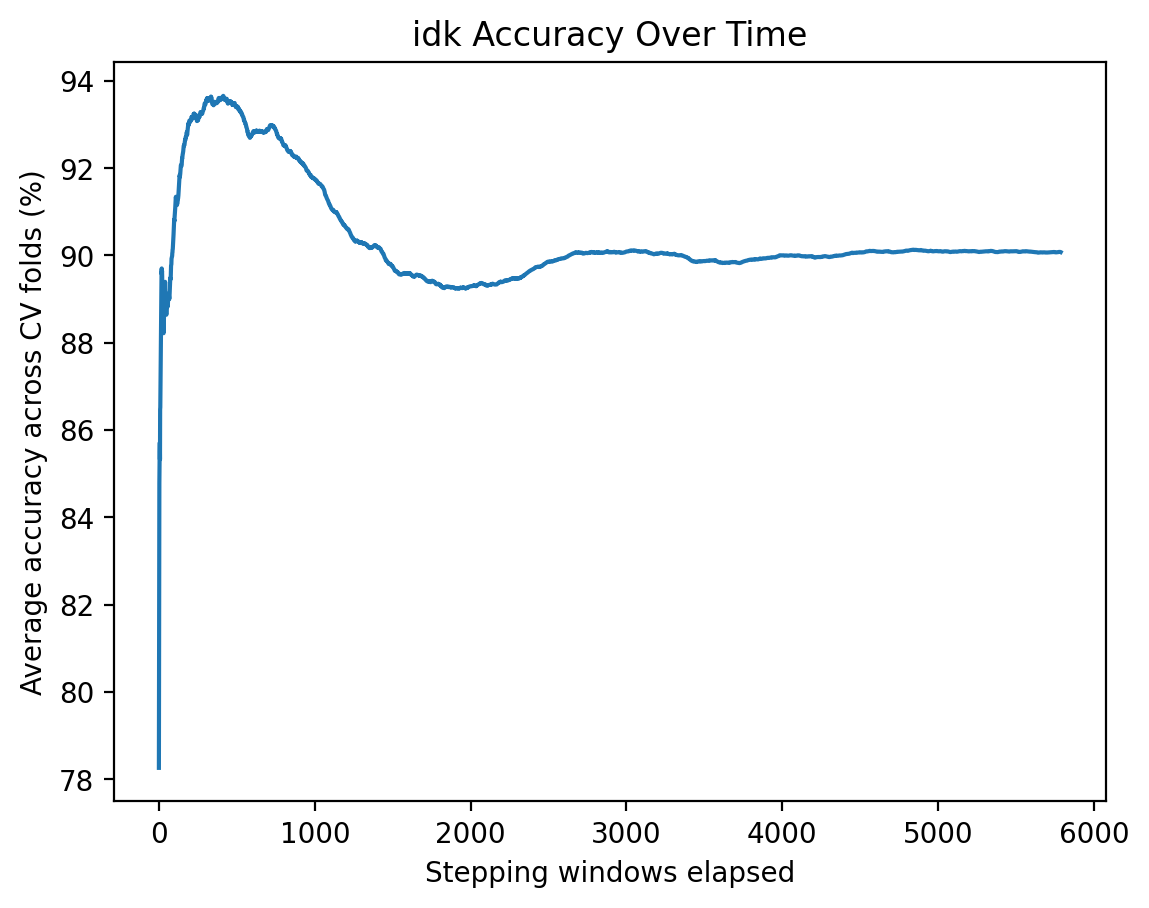

The best parameters were (('max_depth', None),)
Accuracy for each fold: [0.9142857142857143, 0.9304921852247354, 0.9917043740573153, 0.88307130825379, 0.9628187413641502, 0.9391727493917275, 0.8337816633041919, 0.9870682599443444, 0.8906570223025919, 0.8997225525168451, 0.9410097045033257, 0.98462070157249, 0.7998910675381263, 0.8467667790376954, 0.6816957605985038, 0.933205292360222, 0.9705346796887933, 0.9182512144344206, 0.6723788278239708, 0.9445031712473573, 0.9420896741905832, 0.9643612201751737, 0.9596204320613769]
Mean accuracy: 0.9039870911251064
Std accuracy: 0.08496146516324511
Sensitivity for each fold: [0.9143489691434897, 0.9666327050433011, 0.994919168591224, 0.88102112141012, 0.9957356076759062, 0.9415368081676518, 0.8313776618861365, 0.989484061781137, 0.9263987983477281, 0.9005398110661269, 0.5451807228915663, 0.9903728338876248, 0.6689804772234273, nan, nan, 0.959349593495935, 0.9776149776149776, 0.981624184943687, 0.5864922584089696, 0.979840848806366, 0.99384615384

In [50]:
score_reporter(results, False, True)

In [54]:
# Random Forest
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [300],
    "max_depth": [30]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = RandomForestClassifier(**fit_params)
        
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train.astype(np.float32), y_train.astype(np.float32))

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/rf_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

(('max_depth', 30), ('n_estimators', 300)) 0.9364257029378574


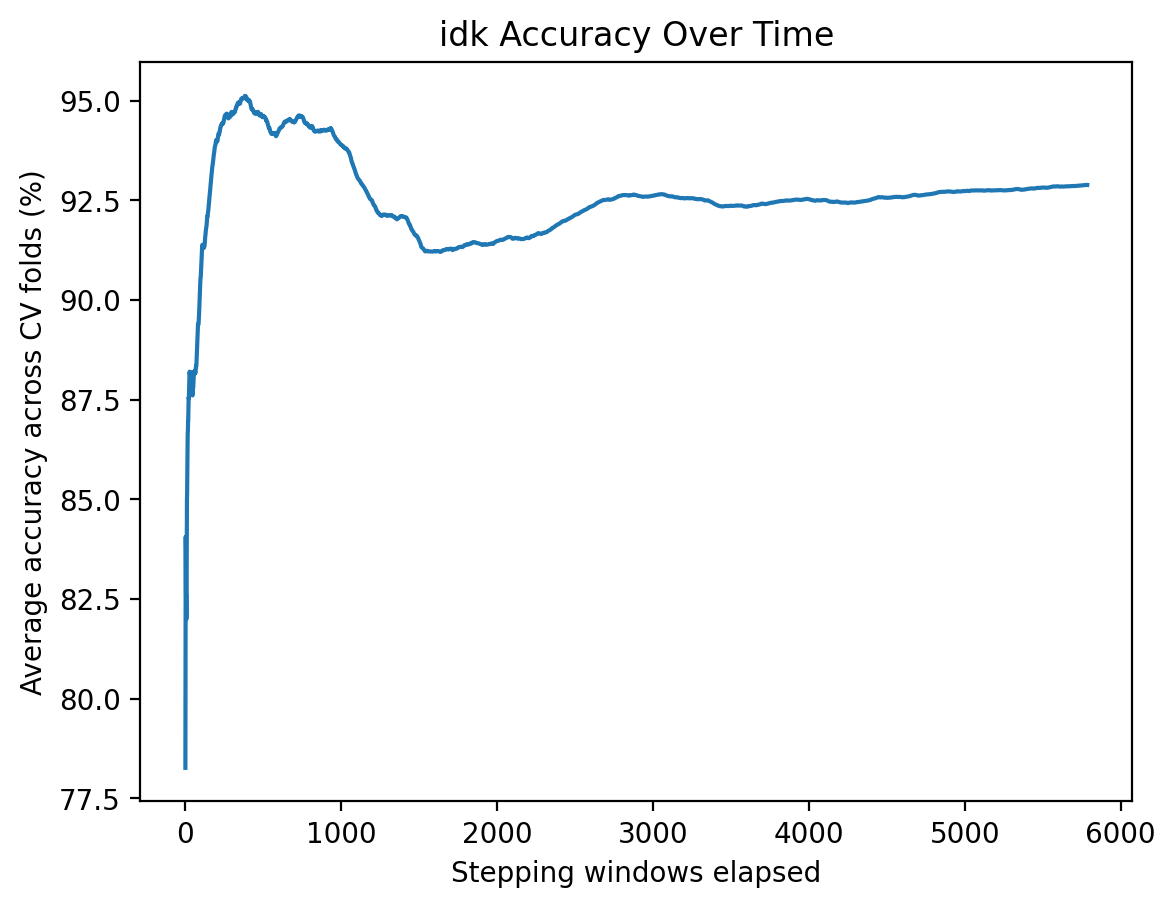

The best parameters were (('max_depth', 30), ('n_estimators', 300))
Accuracy for each fold: [0.9197539302802461, 0.9253470536841083, 0.9945701357466064, 0.8923357664233577, 0.9954779550307751, 0.9604866180048662, 0.8994620040349698, 0.9945981339008021, 0.936829415310428, 0.9036860879904876, 0.9773198124522953, 0.9861759115258337, 0.8596949891067538, 0.9494330370824394, 0.7228927680798005, 0.9825010670081092, 0.983943055785466, 0.9666897987508675, 0.7565402555262625, 0.9710623678646935, 0.9948932693289756, 0.96843853820598, 0.9956591964465981]
Mean accuracy: 0.9364257029378574
Std accuracy: 0.07169424818380904
Sensitivity for each fold: [0.9190535491905355, 0.9747834946510443, 0.9975365665896844, 0.8848199361799118, 0.997867803837953, 0.9603439011284256, 0.867883528900478, 0.9960565231679264, 0.9166353736387532, 0.9036437246963562, 0.5572289156626506, 0.9961491335550499, 0.7498915401301518, nan, nan, 0.974870657797487, 0.9865689865689866, 0.992886781268524, 0.6843299519487454, 0.9867374

In [55]:
score_reporter(results, False, True)

In [56]:
# AdaBoost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [300]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = AdaBoostClassifier(algorithm="SAMME.R",
                                **fit_params)
        fold_results = Parallel(n_jobs=4)(
            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/ada_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
score_reporter(results, False, True)

(('n_estimators', 300),) 0.9275428752239288
The best parameters were (('n_estimators', 300),)
Accuracy for each fold: [0.9145591250854409, 0.9473837491505679, 0.9953242835595777, 0.8928972487366648, 0.9938449943474438, 0.9431630170316302, 0.8904954046177987, 0.9927975118677361, 0.929957805907173, 0.9024970273483948, 0.9737215134663614, 0.988940729220667, 0.8270152505446623, 0.9163346613545816, 0.6773067331670823, 0.9702304737516005, 0.9826187717265353, 0.9769604441360167, 0.68403974852971, 0.9700052854122622, 0.9895822694311102, 0.9791603745092117, 0.9946497072481324]
Mean accuracy: 0.9275428752239288
Std accuracy: 0.08733330782830351
Sensitivity for each fold: [0.9136571191365712, 0.9714722363728986, 0.997228637413395, 0.8848199361799118, 0.997867803837953, 0.9385276732939279, 0.8422425032594524, 0.9939204732172199, 0.9263987983477281, 0.9013495276653172, 0.5180722891566265, 0.9931734640294066, 0.6859002169197397, nan, nan, 0.934589800443459, 0.9833129833129833, 0.989922940130409, 0.5

In [31]:
'''
# Gradient Boost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [350]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = GradientBoostingClassifier(loss="log_loss",
                                         max_depth=8,
                                            **fit_params)
        fold_results = Parallel(n_jobs=4)(
            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/gb_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''

'\n# Gradient Boost\nfolder = \'./joblib_memmap\'\ntry:\n    os.mkdir(folder)\nexcept FileExistsError:\n    pass\n\ndump(X, os.path.join(folder, \'X\'))\nX_memmap = load(os.path.join(folder, \'X\'), mmap_mode=\'r\')\ndump(y, os.path.join(folder, \'y\'))\ny_memmap = load(os.path.join(folder, \'y\'), mmap_mode=\'r\')\n\n#num_combinations = 30\nparams = {\n    "n_estimators": [350]\n}\nparam_grid = ParameterGrid(params)\nprint(f\'Fitting with {len(param_grid)} different parameter combinations\')\nresults = {}\n\nwith tqdm(param_grid) as pbar:\n    for fit_params in pbar:\n        pbar.set_description(f\'Fitting parameter combination: {fit_params}\')\n        \n        clf = GradientBoostingClassifier(loss="log_loss",\n                                         max_depth=8,\n                                            **fit_params)\n        fold_results = Parallel(n_jobs=4)(\n            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)\n            for (train

In [32]:
# score_reporter(results)

In [58]:
# SVC
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    #"kernel": ["linear", "rbf"]
    "verbose": [False]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = LinearSVC(**fit_params)
        
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train, y_train)

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/svc_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [59]:
score_reporter(results, False, True)

(('verbose', False),) 0.8726876737685789
The best parameters were (('verbose', False),)
Accuracy for each fold: [0.88215994531784, 0.9335986797398311, 0.9856711915535445, 0.7662829870859068, 0.9692249717372189, 0.9162043795620438, 0.8651647612642905, 0.9500736618104436, 0.8670283303194696, 0.763905403620029, 0.9690328208483262, 0.9210298945913253, 0.7922657952069717, 0.9676677903769537, 0.4341147132169576, 0.9008749466495946, 0.9452077470617447, 0.9242192921582234, 0.5672277428513486, 0.9086945031712473, 0.9756919620059238, 0.8962549078828148, 0.9702200686452654]
Mean accuracy: 0.8726876737685789
Std accuracy: 0.131951057352436
Sensitivity for each fold: [0.8815552788155527, 0.9639582272032603, 0.9859892224788299, 0.7483665096489895, 0.9651741293532339, 0.9183234819989253, 0.9256844850065189, 0.9507065395990798, 0.8467893353360871, 0.7589743589743589, 0.6445783132530121, 0.9249081043234728, 0.6648590021691974, nan, nan, 0.9689578713968958, 0.9365079365079365, 0.946058091286307, 0.44847

In [20]:
# XGBoost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 30
params = {
    "n_estimators": [1050],
    "max_depth": [5]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = XGBClassifier(learning_rate = 0.1,
                        verbose=None, 
                        eval_metric='logloss',
                        tree_method='gpu_hist',
                        **fit_params)
        fold_results = Parallel(n_jobs=8)(
            delayed(fit_xgboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/xg_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('max_depth', 5), ('n_estimators', 1050)) 0.9462529118130922


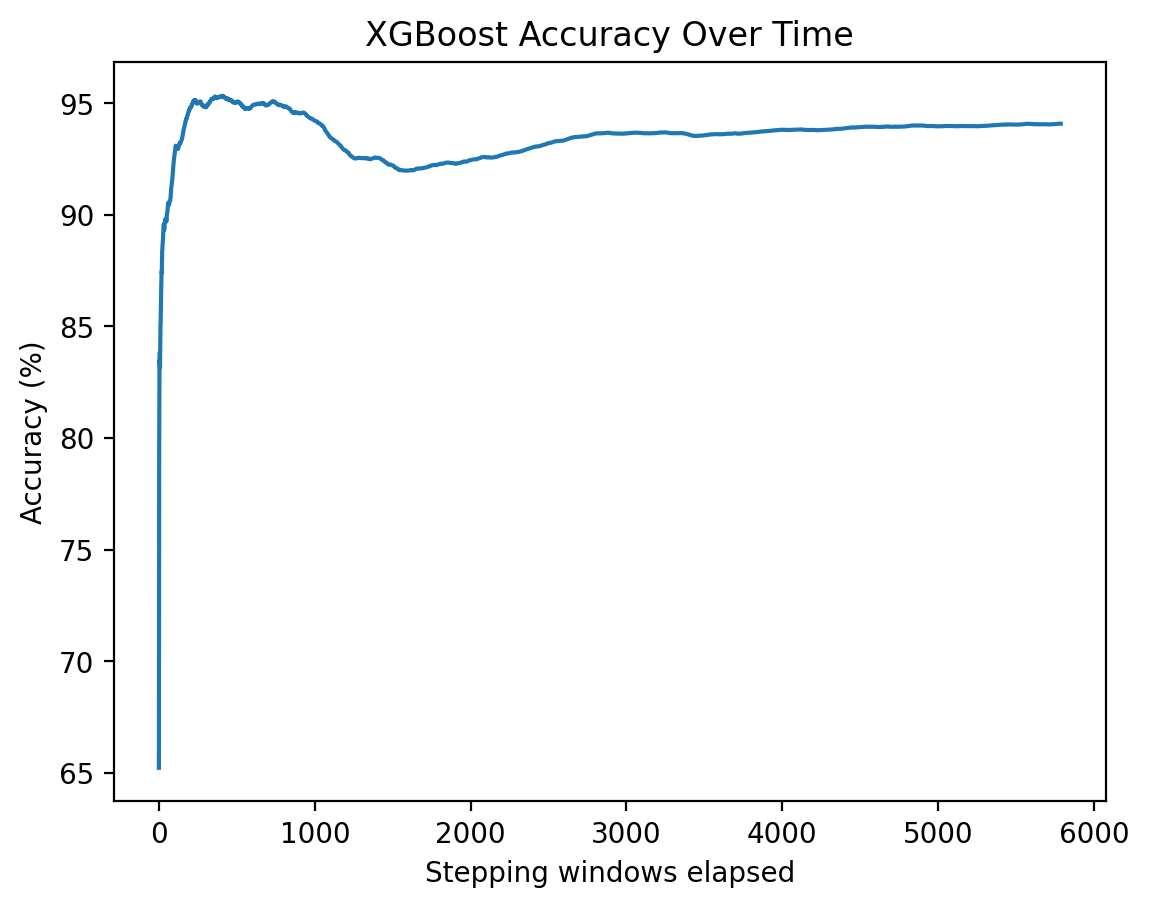

The best parameters were (('max_depth', 5), ('n_estimators', 1050))
Accuracy for each fold: [0.9193438140806562, 0.9340840695078148, 0.9939668174962293, 0.9382369455362156, 0.9968596909935937, 0.9669099756690998, 0.8922887245012329, 0.9952529055491898, 0.950210970464135, 0.9451710926146122, 0.9783011667211864, 0.9891135303265941, 0.8734204793028323, 0.9472877719889672, 0.7550124688279302, 0.9868758002560819, 0.9870882304254263, 0.9830673143650243, 0.7799634962482255, 0.9817653276955602, 0.9937697885813502, 0.9800664451827242, 0.9957601453664445]
Mean accuracy: 0.9462529118130922
Std accuracy: 0.06450883519699802
Sensitivity for each fold: [0.9186384391863844, 0.9745287824758023, 0.9970746728252502, 0.9361799118674974, 0.9992892679459844, 0.9670069854916712, 0.8552803129074316, 0.996878080841275, 0.9496808111152835, 0.945748987854251, 0.536144578313253, 0.9982496061613864, 0.7685466377440348, nan, nan, 0.9715447154471545, 0.987993487993488, 0.990515708358032, 0.7139615589962627, 0.99540

In [21]:
score_reporter(results, True, True, "XGBoost")

In [22]:
# CatBoost
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 15
params = {
    "n_estimators": [650],
    "max_depth": [6]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = CatBoostClassifier(
                        learning_rate=0.1,
                        loss_function='Logloss',
                        task_type="GPU",
                        silent=True,
                        **fit_params)
        fold_results = Parallel(n_jobs=1)(
            delayed(fit_catboost_parallel)(clf, X_memmap, y_memmap, train, test, **fit_params)
            for (train, test) in splits
        )
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/cb_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

(('max_depth', 6), ('n_estimators', 650)) 0.9451157951693866


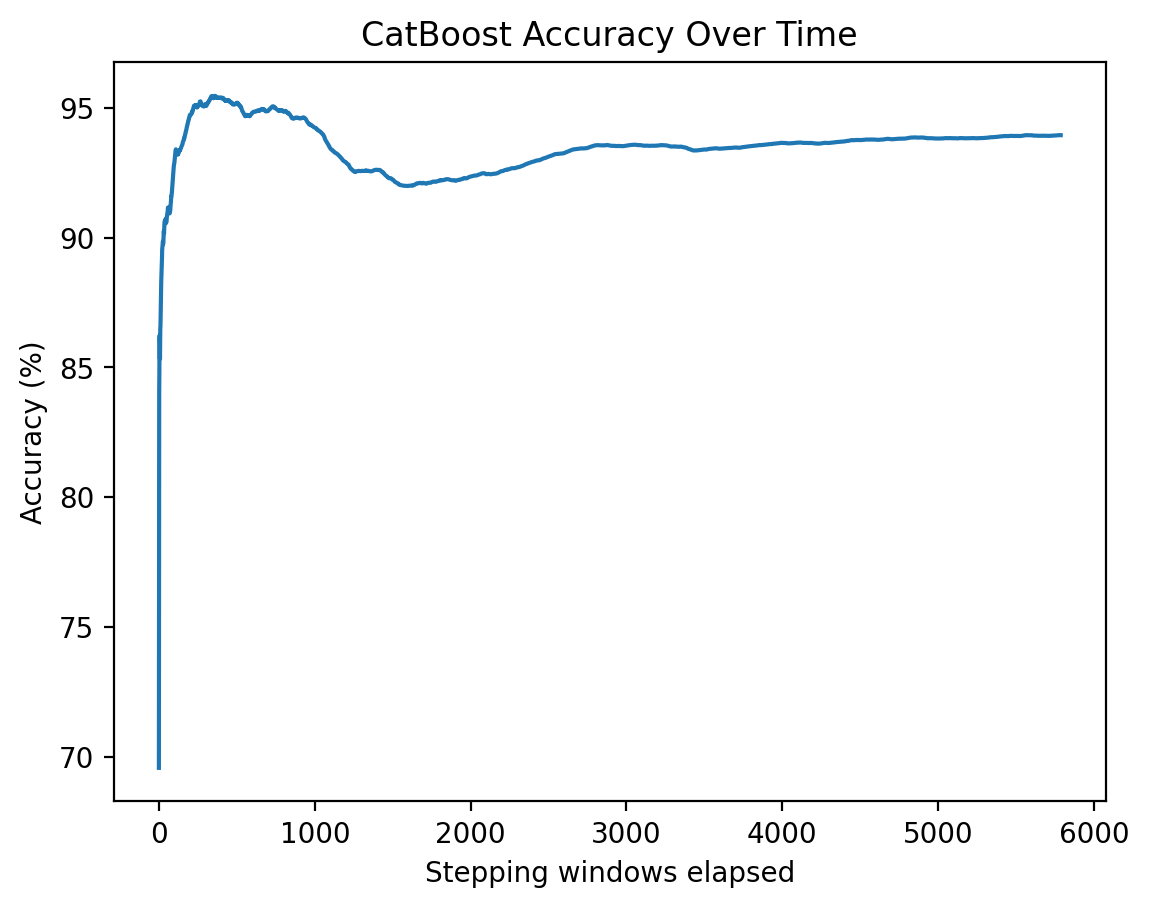

The best parameters were (('max_depth', 6), ('n_estimators', 650))
Accuracy for each fold: [0.9196172248803828, 0.9353460829045723, 0.9945701357466064, 0.9348680516563729, 0.99698530335385, 0.9634063260340633, 0.8945303743555256, 0.9952529055491898, 0.9529837251356239, 0.9376403752146915, 0.9776469305419256, 0.9880767236910316, 0.8639433551198257, 0.9506589028501379, 0.749426433915212, 0.9845283824157064, 0.98692269491806, 0.9850104094378903, 0.7771243155546542, 0.9824260042283298, 0.9951996731692371, 0.9752340682573241, 0.9962648899656774]
Mean accuracy: 0.9451157951693866
Std accuracy: 0.06589430574293427
Sensitivity for each fold: [0.9189151791891518, 0.9721090168110036, 0.997228637413395, 0.9310135237805804, 0.9989339019189766, 0.9634605051047824, 0.8513689700130378, 0.9970423923759448, 0.9478032294404807, 0.9384615384615385, 0.5301204819277109, 0.9971993698582181, 0.7531453362255965, nan, nan, 0.9626755358462675, 0.9877899877899878, 0.991108476585655, 0.7100907634810465, 0.9945181

In [23]:
score_reporter(results, False, True, "CatBoost")

In [26]:
# LightGBM
folder = './joblib_memmap'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

dump(X, os.path.join(folder, 'X'))
X_memmap = load(os.path.join(folder, 'X'), mmap_mode='r')
dump(y, os.path.join(folder, 'y'))
y_memmap = load(os.path.join(folder, 'y'), mmap_mode='r')

#num_combinations = 15
params = {
    "n_estimators": [1000],
    "max_depth": [5]
}
param_grid = ParameterGrid(params)
print(f'Fitting with {len(param_grid)} different parameter combinations')
results = {}

with tqdm(param_grid) as pbar:
    for fit_params in pbar:
        pbar.set_description(f'Fitting parameter combination: {fit_params}')
        
        clf = lightgbm.LGBMClassifier(
                        learning_rate=0.1,
                        device="gpu",
                        verbose=-1,
                        **fit_params)
        fold_results = []
        for (train, test) in tqdm(splits, leave=False):
            X_train = X.iloc[train]
            y_train = y.iloc[train]

            X_test = X.iloc[test]
            y_test = y.iloc[test]

            cloned_clf = clone(clf)
            cloned_clf.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], 
                   eval_metric='logloss')

            pred_values = cloned_clf.predict(X_test)
    
            total_seen = 0
            total_correct = 0
            subject_acc = []
            for idx, pred in enumerate(pred_values):
                total_seen+=1
                if pred==y_test.iloc[idx]:
                    total_correct+=1
                subject_acc.append(total_correct/total_seen)

            cm = confusion_matrix(y_test.values.reshape(y_test.shape[0]), pred_values)
            sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
            specificity = cm[1][1]/(cm[1][0]+cm[1][1])
            precision = (cm[0][0])/(cm[0][0]+cm[1][0])

            results_dict = {
                "accuracy": accuracy_score(y_test, pred_values),
                "sensitivity": sensitivity,
                "specificity": specificity,
                "precision": precision,
                "f1_score": (2*precision*sensitivity)/(precision+sensitivity),
                "feature_importances": {A: B for A, B in zip(cloned_clf.feature_name_, cloned_clf.feature_importances_)}, 
                "subject_acc": subject_acc
            }

            fold_results.append(results_dict)
        
        current_results = {}
        for i, result in enumerate(fold_results):
            current_results[f"split{i}_accuracy"] = result["accuracy"]
            current_results[f"split{i}_sensitivity"] = result["sensitivity"]
            current_results[f"split{i}_specificity"] = result["specificity"]
            current_results[f"split{i}_precision"] = result["precision"]
            current_results[f"split{i}_f1_score"] = result["f1_score"]
            current_results[f"split{i}_feature_importances"] = result["feature_importances"]
            current_results[f"split{i}_subject_acc"] = result["subject_acc"]
        results[tuple(sorted(fit_params.items()))] = current_results
        results[tuple(sorted(fit_params.items()))]['folds'] = len(splits)

with open(f'saved_results_{current_weight}/lg_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Fitting with 1 different parameter combinations


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

(('max_depth', 5), ('n_estimators', 1000)) 0.9446804623060564


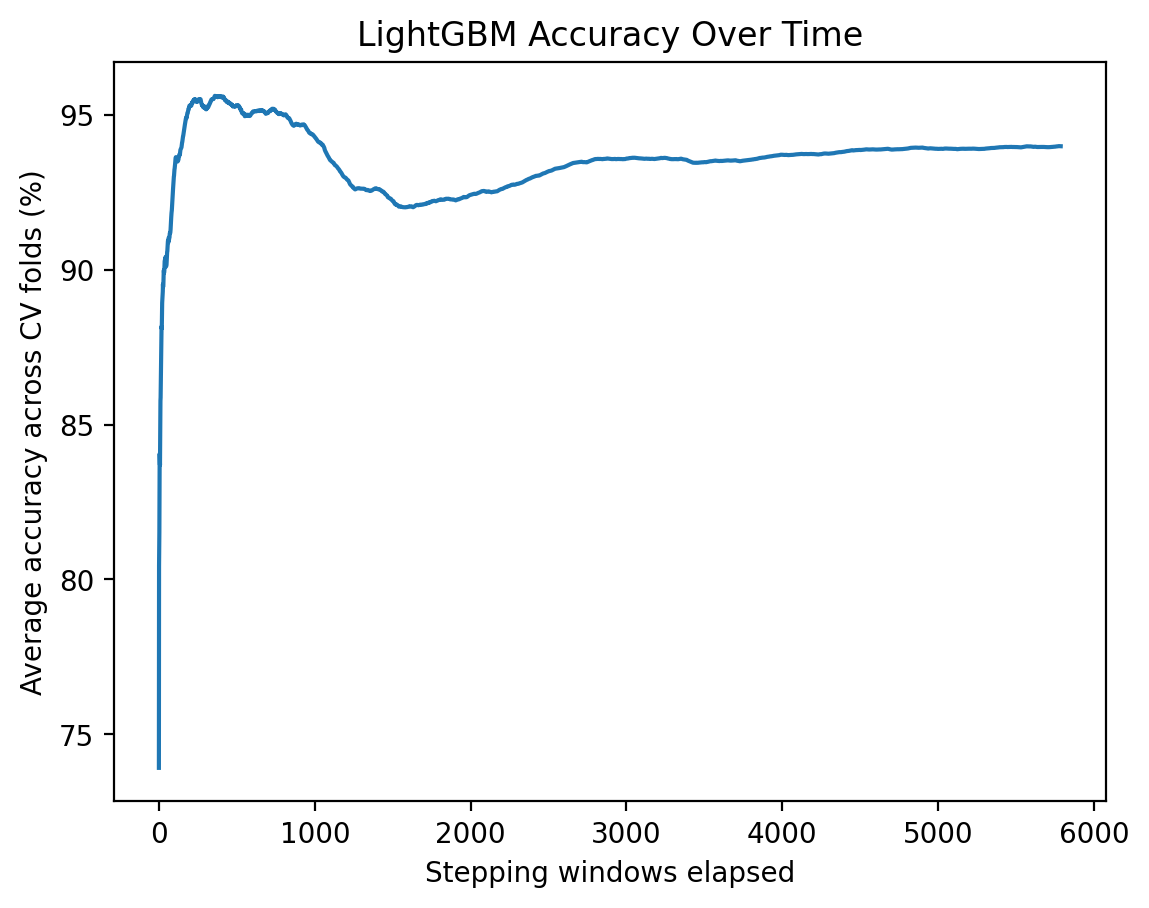

The best parameters were (('max_depth', 5), ('n_estimators', 1000))
Accuracy for each fold: [0.9203007518796993, 0.9363168624405398, 0.9945701357466064, 0.937394722066255, 0.9962316291923126, 0.9684671532846715, 0.8895987446760816, 0.994761826812899, 0.9493670886075949, 0.9445105033690051, 0.9777559699051358, 0.988940729220667, 0.860239651416122, 0.9457554397793442, 0.7397506234413965, 0.9873026034997866, 0.9880814434696242, 0.9827897293546148, 0.7773271141756236, 0.9811046511627907, 0.9939740578081911, 0.9770462096043492, 0.9960629921259843]
Mean accuracy: 0.9446804623060564
Std accuracy: 0.06749508389326689
Sensitivity for each fold: [0.9196070291960703, 0.9754202750891493, 0.9975365665896844, 0.934052575596414, 0.9996446339729922, 0.969371305749597, 0.8470230334637114, 0.9965494577719356, 0.9504318437852046, 0.945748987854251, 0.5331325301204819, 0.9975494486259409, 0.7457700650759219, nan, nan, 0.9719142645971914, 0.9894179894179894, 0.989922940130409, 0.7111585691404164, 0.9954022

In [37]:
score_reporter(results, False, True, "LightGBM")